In [14]:
%matplotlib inline

# libs

# data
import pandas as pd
import numpy as np

# CNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

# plot
import matplotlib.pyplot as plt

In [15]:
path = './data/full.csv'

# load full data
D = pd.read_csv(path, index_col=0)

In [16]:
# extract inputs/targets
target_cols = list(filter(lambda x: 'c1_c0' in x, D.columns.values))
input_cols  = list(filter(lambda x: 'c1_c0' not in x, D.columns.values))
InputDF = D[input_cols]
TargetDF = D[target_cols]

# into numpy format
InputDF = InputDF.as_matrix()
TargetDF = TargetDF.as_matrix()

In [17]:
# 6 values, from 440 symbols, over 2768 days
total_days = InputDF.shape[0]
channels = 6
tickers = InputDF.shape[1]/channels
InputDF = np.reshape(InputDF, (total_days, tickers, channels))

In [18]:
# data params
test_size = 500;
window_size = 28;

X_train = np.array([InputDF[i:i + window_size] for i in range(InputDF.shape[0] - (test_size + window_size - 1) )])
X_test = np.array([InputDF[i:i + window_size] for i in range(InputDF.shape[0] - (test_size + window_size - 1), InputDF.shape[0] - window_size + 1)])

def decision(x):
    margin = 0.01
    print x.shape
    labels = np.zeros((x.shape[0], x.shape[1] * 3))
    print labels.shape
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i][j] >= np.log(1 + margin)):
                labels[i][j * 3: (j+1) * 3] = [0, 0, 1]
            elif (x[i][j] <= np.log(1 - margin)):
                labels[i][j * 3: (j+1) * 3] = [1, 0, 0] 
            else:
                labels[i][j * 3: (j+1) * 3] = [0, 1, 0] 
    # 2 -> buy
    # 1 -> do nothing
    # 0 -> sell
    return labels


y_all = decision(TargetDF)
y_train = y_all[window_size - 1 : -test_size]
y_test = y_all[-test_size:]


# data shape
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(2768, 440)
(2768, 1320)
(2241, 28, 440, 6) (2241, 1320)
(500, 28, 440, 6) (500, 1320)


In [19]:
# KERAS STARTS HERE
batch_size = 32
epochs = 100

# dimensions
input_shape = (window_size, tickers, channels)

In [20]:
# model definition
# ADD PADDING??
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(1320))
model.add(Activation('sigmoid'))

print model.summary()

# model.load_weights('weights-lowhidden.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 436, 16)       2416      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 432, 32)       12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 216, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 214, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 212, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 106, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 106, 128)       0         
__________

In [21]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])


model.load_weights('weights-best-extraconv.h5')

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs/3_sigmoid_extraconv_extrarun')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_test, y_test),
#           callbacks=[tensorboard, reduce_lr])

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)

print 'Test loss:', score[0]
print 'Test accuracy:', score[1]


Test loss: 0.570891589165
Test accuracy: 0.715906037807


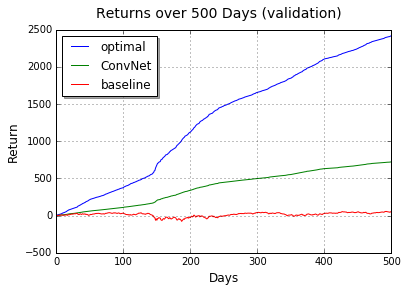

In [24]:
predictions = model.predict(X_test)

actions_actual = np.argmax(y_test.reshape(500, 440, 3), axis=-1) - 1

actions_predicted = np.argmax(predictions.reshape(500, 440, 3), axis=-1) - 1

x_axis = np.arange(len(y_test))

fig, ax = plt.subplots()
fig.suptitle('Returns over 500 Days (validation)', fontsize=14)

line0 = ax.plot(x_axis, (actions_actual * TargetDF[-test_size:]).sum(1).cumsum(), label="optimal")
# ax.plot(x_axis, (actions_predicted * TargetDF[-test_size:]).sum(1).cumsum())

line1 = ax.plot(x_axis, (real * TargetDF[-test_size:]).sum(1).cumsum(), label="ConvNet")
line2 = ax.plot(x_axis, (1 * TargetDF[-test_size:]).sum(1).cumsum(), label="baseline")

ax.legend(loc='upper left', shadow=True)

plt.xlabel('Days', fontsize=12)
plt.ylabel('Return', fontsize=12)

# print normalize(predictions)
# ax.set_ylim(ymin=-500, ymax=2500)
ax.set_xlim(xmin=0, xmax=500)

# ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')

plt.grid()
plt.show()

In [25]:
confusion_matrix = np.ndarray((3, 3))
confusion_matrix[0][0] = len(np.where(actions_predicted[np.where(actions_actual == -1)] == -1)[0])
confusion_matrix[0][1] = len(np.where(actions_predicted[np.where(actions_actual == -1)] == 0)[0])
confusion_matrix[0][2] = len(np.where(actions_predicted[np.where(actions_actual == -1)] == 1)[0])
confusion_matrix[1][0] = len(np.where(actions_predicted[np.where(actions_actual == 0)] == -1)[0])
confusion_matrix[1][1] = len(np.where(actions_predicted[np.where(actions_actual == 0)] == 0)[0])
confusion_matrix[1][2] = len(np.where(actions_predicted[np.where(actions_actual == 0)] == 1)[0])
confusion_matrix[2][0] = len(np.where(actions_predicted[np.where(actions_actual == 1)] == -1)[0])
confusion_matrix[2][1] = len(np.where(actions_predicted[np.where(actions_actual == 1)] == 0)[0])
confusion_matrix[2][2] = len(np.where(actions_predicted[np.where(actions_actual == 1)] == 1)[0])


print '\n'
print 'Confusion Matrix: '
print confusion_matrix

print '\n'
print 'Accuracy :', np.sum(confusion_matrix.diagonal()) / float(np.sum(confusion_matrix))



Confusion Matrix: 
[[   2450.   42928.    4498.]
 [   1581.  111225.    3336.]
 [   2967.   46311.    4704.]]


Accuracy : 0.538086363636
